In [2]:
# First we import the module and start up the Matlab interpreter

import os
import numpy as np
from pace_neutrons import Matlab
m = Matlab()


Trying MATLAB version: 2022b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2022b.ctf))
Searching for Matlab 9.13 in /opt/matlab2021b
Searching for Matlab 9.13 in /opt
Trying MATLAB version: 2021b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2021b.ctf))
Searching for Matlab 9.11 in /opt/matlab2021b
Found Matlab 9.11 glnxa64 at /opt/matlab2021b
Interface opened
All features have moved to hor_config


!==================================================================!

All features have moved to hor_config

!==================================================================!
!                           Horace 4.0.0                           !

!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !

!                  I. Bustinduy, and T.G. Perring                  !
!                                  

# Simulation and Fitting

For fitting and simulating, Horace makes a difference between the *(Q,E)* - that is `[h,k,l,E]` - and "plot" coordinate system (defined by the projection `[u,v,w,E]` vectors. You can fit a given `sqw` object with *either* a function defined by the `[h,k,l,E]` coordinates *or* the `[u,v,w,E]` coordinates, but you have to use different Horace functions. You can only fit `dnd` objects with functions defined on the plot coordinates `[u,v,w,E]`.

Generally, you fit peak functions (Gaussian, Lorentzians, etc) using the plot coordinates - this means that a function fitting a 1D cut will accept only one dependent coordinate; a function fitting a 2D slice will require 2 input coordinates etc. 

On the other hand, spin wave or phonon models are defined in terms of the (Q,E) coordinates, and you usually have to give all four `[h,k,l,E]` coordinates regardless of the dimension of the cut because they are evaluated on the pixels contributing to each bin.

We will start with showing a simulation of a simple peak (Gaussian) over a cut, and then show a S(Q,w) model to give you a flavour of the syntax.

## Simulation 

We start by going back to some 1D cuts we did earlier this morning, along the [HH0] direction at different energy transfer.

(Aside, why would we want to do constant energy cuts along Q instead of constant Q cuts along energy?)

*** Step 1 of 1; Read data for   200028 pixels -- processing data...
 ----->  retained     53790 pixels

*** Completed cat_pixels using 1 pages in 0.041928 sec.

*** Step 1 of 1; Read data for   284020 pixels -- processing data...
 ----->  retained     70892 pixels

*** Completed cat_pixels using 1 pages in 0.011619 sec.

*** Step 1 of 1; Read data for   458454 pixels -- processing data...
 ----->  retained     98358 pixels

*** Completed cat_pixels using 1 pages in 0.008334 sec.

*** Step 1 of 1; Read data for   508448 pixels -- processing data...
 ----->  retained    139698 pixels

*** Completed cat_pixels using 1 pages in 0.010681 sec.

*** Step 1 of 1; Read data for   467166 pixels -- processing data...
 ----->  retained    148412 pixels

*** Completed cat_pixels using 1 pages in 0.0199 sec.



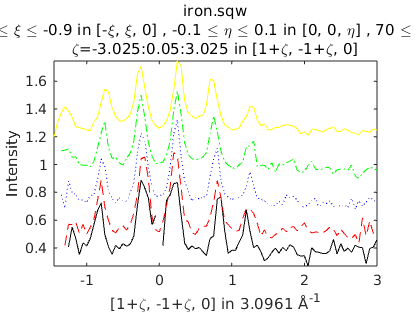

In [3]:
sqw_file = '/mnt/ceph-training/course_materials/sqw_files/iron.sqw'
proj = m.line_proj([1,1,0], [-1,1,0], 'type', 'rrr')

# Make an array of 1d cuts:
energy_range = range(80, 161, 20)
my_cuts = m.sqw.empty()
for i, en in enumerate(energy_range):
    my_cuts[i] = m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.1,-0.9], [-0.1,0.1], [-10+en, 10+en])

# Plots the cuts using a vectorised operation, offsetting each cut by 0.3 units in y
m.acolor(['black', 'red', 'blue', 'green', 'yellow'])
m.amark(['+', 'o', '*', '.', 'x', 's'], 6)
my_cut_offset = my_cuts + np.arange(0, 1.3, 0.3)
m.dl(my_cut_offset)

We now simulate a set of peak functions to the first cut, with parameters judged "by eye".

We will be using the `mgauss` function to fit, and it takes `3*n` parameters where `n` is the number of peaks, and the parameters are `[area, centre, width]` in that order repeated.

How many peaks are there? What are the approximate values of their centres?

Use the `func_eval` function ([documentation here](https://pace-neutrons.github.io/Horace/unstable/manual/Simulation.html)) to evaluate the Gaussians on the data coordinates of the cut and plot it.

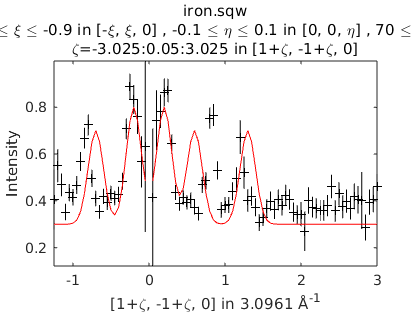

In [4]:
pars_in = [0.4,-0.7,0.1, 0.5,-0.2,0.1, 0.5,0.2,0.1, 0.4,0.6,0.1, 0.4,1.3,0.1]

mgauss = m.eval('@mgauss')   # We need to do this to get a Matlab function handle to pass to func_eval
peaks_sim = m.func_eval(my_cuts[0], mgauss, pars_in)

m.acolor('black')
m.plot(my_cuts[0])
m.acolor('red')
# Note the peaks simulation doesn't have a background - we add a flat background to match the data
m.pl(peaks_sim + 0.3)

Next we run a simulation of a S(q,w) model function - in fact a ferromagnetic spin wave model which should be able to fit the spinwaves in iron. It is described by the following equations:

$$ E_0 = 8J (1 - \cos(\pi h) \cos(\pi k) \cos(\pi l) $$
$$ B = \frac{E}{1 - \exp\left(- \frac{1.602 E}{T}\right)} $$
$$ S(\mathbf{Q}, E) = \frac{AB}{\pi} \frac{4 \Gamma E_0 }{(E^2 - E_0^2)^2 + 4(\Gamma E)^2} $$

Where $A$ is an amplitude scale factor, $T$ is the temperature in Kelvin $J$ is a ferromagnetic exchange constant in meV, $\Gamma$ is an energy broadening term in meV.

The $E_0$ term is the dispersion, and $\mathbf{Q}=(h, k, l)$.

You should define the $S(\mathbf{Q},E)$ as a Python function which takes $h, k, l, E$ as coordinate inputs as well as the parameters $J, \Delta, \Gamma, A$ (the sample temperature $T$ is fixed at 10K for our measurements). The parameters should be given as a list / vector of values `p`.

Then use the `sqw_eval` function ([documentation here](https://pace-neutrons.github.io/Horace/unstable/manual/Simulation.html#sqw-eval)) to evaluate it on the cut.

In [5]:
def fm_sqw(h, k, l, E, p):
    J = p[0]
    Gamma = p[1]
    A = p[2]
    print(h.shape)
    vv = m.cos(h)
    print(vv.shape)
    E0 = 8*J * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    B = E / (1 - np.exp(-1.602 * E / 10))
    return (A * B * 4 * Gamma * E0 / np.pi) / ((E**2 - E0**2)**2 + 4*(Gamma*E)**2)

In [ ]:
J = 35
Gamma = 30
A = 80

w_cal = m.sqw_eval(my_cuts[0], fm_sqw, [J, Gamma, A])
# Plots the data and model together
m.plot(my_cuts[0])
m.pl(w_cal + 0.3)

(53790, 1)


Explore with different values of the parameters and see if you can get close to the data.

Start by trying to match the amplitude $A$ (put any value for $J$ and $\Gamma$. Then try to match $\Gamma$ and then finally $J$ to see if you can reproduce the $Q$ spacing of the peaks.

What do you notice about the amplitude of the data vs that of the calculation?

----

Finally to end the simulations section, we will make a dispersion plot along a line of Q points, using the FM spin wave definition above, using the `disp2sqw_plot` function ([documentation here](https://pace-neutrons.github.io/Horace/unstable/manual/Simulation.html#disp2sqw-plot)).

This function takes a slightly different input from `sqw_eval` - it expects both the intensity $S$ and the dispersion relation $E_0$ as a function of $Q$. In this case, we should return the $S(\mathbf{Q},E=E_0)$ (the intensity at $E=E_0$) value.

In [32]:
def fm_disp(h, k, l, p):
    J = p[0]
    Gamma = p[1]
    A = p[2]
    E0 = 8*J * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    E = E0
    B = E / (1 - np.exp(-1.602 * E / 10))
    S = (A * B * 4 * Gamma * E0 / np.pi) / (4*(Gamma*E)**2)
    return E0, S

/tmp/ipykernel_770352/4291034925.py:7: RuntimeWarning: invalid value encountered in divide
  B = E / (1 - np.exp(-1.602 * E / 10))


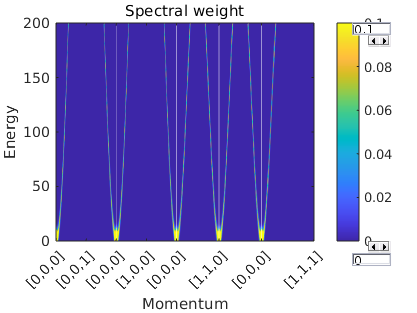

In [33]:
alatt = [2.87, 2.87, 2.87]
angdeg = [90, 90, 90]
lattice = alatt + angdeg

# Reciprocal lattice points to draw dispersion between:
rlp = [[0,0,0], [0,0,1], [0,0,0], [1,0,0], [0,0,0], [1,1,0], [0,0,0], [1,1,1]]
# Input parameters
pars = [35, 30, 80]
# Energy grid
ecent = [0, 0.1, 200];
# Energy broadening term
fwhh = 10

m.disp2sqw_plot(lattice, rlp, fm_disp, pars, ecent, fwhh)
m.lz(0,0.1)

Finally... above notice that the simulated amplitude is equal for all peaks in the 1D cut, but in the data, as Q increases the peak height falls - this is because of the magnetic form factor of iron, which has the following form:

```
# Parameters for the form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114
q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
```

Add a prefactor of `ff**2` to your expression for $S(\mathbf{Q},E)$ and replot and see if you get better agreement in the above.

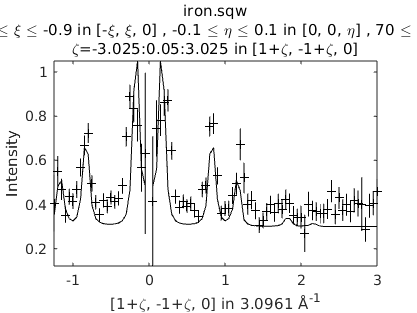

In [4]:
# Parameters for the form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114

# Define the Python function
def fm_sqw(h, k, l, E, p):
    J = p[0]
    Gamma = p[1]
    Amp = p[2]
    E0 = 8*J * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    Biso = E / (1 - np.exp(-1.602 * E / 10))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (Amp * Biso * 4 * Gamma * E0 / np.pi) / ((E**2 - E0**2)**2 + 4*(Gamma*E)**2)

J = 35      # Exchange parameter in meV
Gamma = 30  # Intrinsic linewidth in meV (inversely proportional to excitation lifetime)
Amp = 300   # Magnitude of the intensity of the excitation (arbitrary units)

w_cal = m.sqw_eval(my_cuts[0], fm_sqw, [J, Gamma, Amp])
# Plots the data and model together
m.plot(my_cuts[0])
m.pl(w_cal + 0.3)

## Fitting a single 1D cut with some peaks

We now try to fit a set of Gaussian functions to the peaks in the first cut of the set of cuts we made at the start of the session

Look at first curve - how many peaks are there? We will be using the `mgauss` function to fit, and it takes `3*n` parameters where `n` is the number of peaks, and the parameters are `[area, centre, width]` in that order repeated.

It does not accept a background offset, so first subtract a constant background from the first cut, then use the `multifit` class to fit it.

Fitted parameters are:
0.316(0.066) -0.833(0.012) 0.054(0.013)
0.493(0.075) -0.221(0.014) 0.071(0.013)
0.511(0.076) 0.208(0.014) 0.068(0.013)
0.116(0.013) 0.032(0.900) 2.705(1.396)
0.264(0.121) 1.203(0.018) 0.037(0.015)


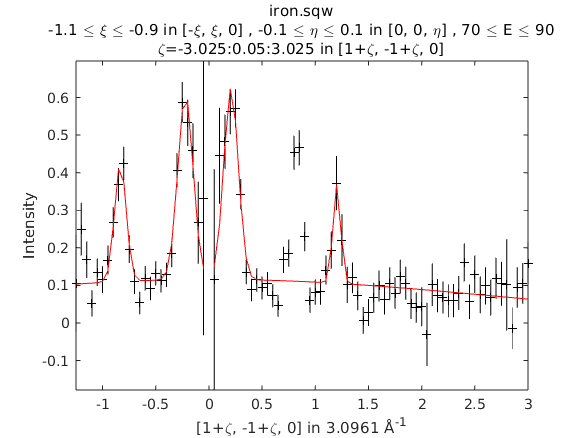

In [15]:
%matlab_plot_mode inline

#pars_in = [?, ?, ?,  # area, centre, width of first peak
#           ?, ?, ?,
#           ????]
pars_in = [0.4,-0.7,0.1, 0.5,-0.2,0.1, 0.5,0.2,0.1, 0.4,0.6,0.1, 0.4,1.3,0.1]

mfobj = m.multifit_func(my_cuts[0] - 0.3)
mgauss = m.eval('@mgauss')  # We need to do this to get a Matlab function handle to pass to multifit
mfobj = mfobj.set_fun(mgauss, pars_in)
wfit, fitdata = mfobj.fit()

m.acolor('black')
m.plot(my_cuts[0] - 0.3)
m.acolor('red')
m.pl(wfit)

print('Fitted parameters are:')
fitpars = np.squeeze(fitdata['p'])
fiterrs = np.squeeze(fitdata['sig'])
for ii in range(int(len(pars_in)/3)):
    print(f"{fitpars[ii*3]:0.3f}({fiterrs[ii*3]:0.3f}) {fitpars[ii*3+1]:0.3f}({fiterrs[ii*3+1]:0.3f}) {fitpars[ii*3+2]:0.3f}({fiterrs[ii*3+2]:0.3f})")


The `fitdata` structure/dictionary has a lot of information about the fit, including the covariance matrix. Let's print it out and see. 

In [25]:
np.set_printoptions(linewidth=140, precision=3, suppress=True)
print(fitdata['corr'])

[[ 1.000  0.026 -0.457  0.012 -0.002  0.036  0.009 -0.003  0.011 -0.093  0.152 -0.087 -0.002 -0.001 -0.004]
 [ 0.026  1.000 -0.066  0.001  0.001 -0.002  0.002  0.000  0.007 -0.019 -0.052  0.055  0.003 -0.000  0.006]
 [-0.457 -0.066  1.000  0.028 -0.004  0.081  0.020 -0.006  0.026 -0.210  0.334 -0.191 -0.004 -0.001 -0.008]
 [ 0.012  0.001  0.028  1.000 -0.017 -0.470  0.012 -0.002  0.024 -0.111  0.014  0.038  0.004 -0.000  0.010]
 [-0.002  0.001 -0.004 -0.017  1.000  0.490  0.001  0.000  0.003 -0.011 -0.019  0.021  0.001  0.000  0.003]
 [ 0.036 -0.002  0.081 -0.470  0.490  1.000  0.022 -0.004  0.040 -0.215  0.103  0.010  0.005 -0.001  0.012]
 [ 0.009  0.002  0.020  0.012  0.001  0.022  1.000  0.006 -0.446 -0.106 -0.008  0.052  0.005 -0.000  0.012]
 [-0.003  0.000 -0.006 -0.002  0.000 -0.004  0.006  1.000 -0.549  0.017 -0.009 -0.001 -0.000  0.000 -0.001]
 [ 0.011  0.007  0.026  0.024  0.003  0.040 -0.446 -0.549  1.000 -0.220 -0.063  0.138  0.012 -0.001  0.029]
 [-0.093 -0.019 -0.210 -0.11

How can we improve this fit? (Hint: which variables have high covariance, indicating that they are correlated / not independent - consider fixing some of them)

Fitted parameters are:
0.364(0.040) -0.841(0.014) 0.100(0.000)
0.565(0.061) -0.221(0.014) 0.100(0.000)
0.582(0.066) 0.199(0.014) 0.100(0.000)
0.350(0.039) 0.817(0.014) 0.100(0.000)
0.251(0.053) 1.215(0.024) 0.100(0.000)


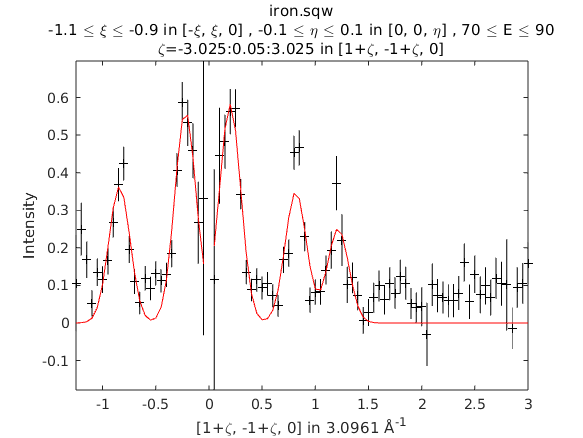

In [26]:
# Run fit again, but fixing some parameters. 
# We specify this as a vector of boolean values indicating which parameters are *free* to vary

pars_in = [0.4,-0.7,0.1, 0.5,-0.2,0.1, 0.5,0.2,0.1, 0.4,0.6,0.1, 0.4,1.3,0.1]
pars_free = [1, 1, 0,    1, 1, 0,      1, 1, 0,     1, 1, 0,     1, 1, 0]

mfobj = m.multifit_func(my_cuts[0] - 0.3)
mgauss = m.eval('@mgauss')  # We need to do this to get a Matlab function handle to pass to multifit
mfobj = mfobj.set_fun(mgauss, pars_in)
mfobj = mfobj.set_free(pars_free)
wfit, fitdata = mfobj.fit()

m.acolor('black')
m.plot(my_cuts[0] - 0.3)
m.acolor('red')
m.pl(wfit)

print('Fitted parameters are:')
fitpars = np.squeeze(fitdata['p'])
fiterrs = np.squeeze(fitdata['sig'])
for ii in range(int(len(pars_in)/3)):
    print(f"{fitpars[ii*3]:0.3f}({fiterrs[ii*3]:0.3f}) {fitpars[ii*3+1]:0.3f}({fiterrs[ii*3+1]:0.3f}) {fitpars[ii*3+2]:0.3f}({fiterrs[ii*3+2]:0.3f})")


It's better but still not so good - there are still too many parameters.

Notice that the peak positions should be symmetric about Q=0 - we can thus fix the centre positions of those peaks to be negative of each other. We can do this using "parameter bindings", [described here in the documentation](https://pace-neutrons.github.io/Horace/unstable/manual/Multifit.html#binding-parameters).

The basic syntax is that each binding is a set of three values in a cell array, denoting:

```
{index_bound_par, index_free_par, ratio}
```

So, say we put the first peak around 0.9 and the second peak around -0.9, the peak position is thus parameter index 2 and 5 (in Matlab 1-based indexing because this is refered to by Horace code which is in Matlab). We would thus use:

```
{2, 5, -1}
```

To specify then bindings.

Now try to fit with binding the positive and negative peak centres in Q.

Fitted parameters are:
0.360(0.040) -0.828(0.010) 0.100(0.000)
0.586(0.060) -0.210(0.010) 0.100(0.000)
0.555(0.058) 0.210(0.010) 0.100(0.000)
0.350(0.040) 0.828(0.010) 0.100(0.000)
0.248(0.053) 1.217(0.024) 0.100(0.000)


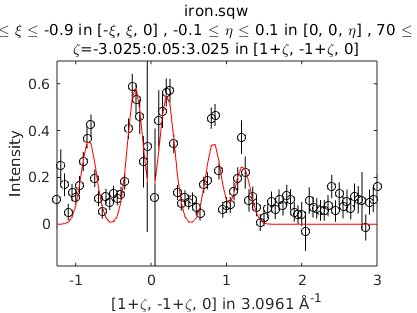

In [44]:
# Run fit again, but fixing some parameters. 
# We specify this as a vector of boolean values indicating which parameters are *free* to vary

pars_in = [0.4,-0.7,0.1, 0.5,-0.2,0.1, 0.5,0.2,0.1, 0.4,0.6,0.1, 0.4,1.3,0.1]
pars_free = [1, 1, 0,    1, 1, 0,      1, 1, 0,     1, 1, 0,     1, 1, 0]
pars_bind = ((2, 11, -1), (5, 8, -1))

mfobj = m.multifit_func(my_cuts[0] - 0.3)
mgauss = m.eval('@mgauss')  # We need to do this to get a Matlab function handle to pass to multifit
mfobj = mfobj.set_fun(mgauss, pars_in)
mfobj = mfobj.set_free(pars_free)
mfobj = mfobj.set_bind(pars_bind)
wfit, fitdata = mfobj.fit()

m.acolor('black')
m.plot(my_cuts[0] - 0.3)
m.acolor('red')
m.pl(wfit)

print('Fitted parameters are:')
fitpars = np.squeeze(fitdata['p'])
fiterrs = np.squeeze(fitdata['sig'])
for ii in range(int(len(pars_in)/3)):
    print(f"{fitpars[ii*3]:0.3f}({fiterrs[ii*3]:0.3f}) {fitpars[ii*3+1]:0.3f}({fiterrs[ii*3+1]:0.3f}) {fitpars[ii*3+2]:0.3f}({fiterrs[ii*3+2]:0.3f})")


Finally, we can also set a background function, rather than just subtracting a constant from the data before fitting. [The documentation is here](https://pace-neutrons.github.io/Horace/unstable/manual/Multifit.html#background-functions).

We will use the `linear_bg` function which takes two parameters `[yintercept, slope]`. Use a zero slope and `0.3` as the y-intercept to start.

Fitted parameters are:
0.218(0.050) -0.845(0.023) 0.100(0.000)
0.457(0.069) -0.202(0.019) 0.100(0.000)
0.485(0.076) 0.179(0.020) 0.100(0.000)
-0.733(498.447) 1.142(3.585) 0.100(0.000)
0.838(498.457) 1.153(3.084) 0.100(0.000)


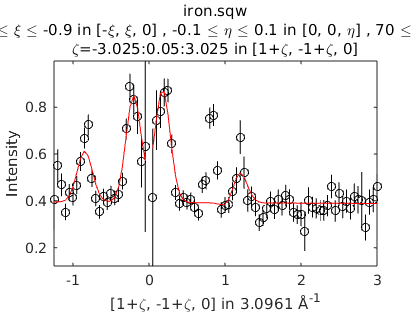

In [48]:
# Run fit again, but fixing some parameters. 
# We specify this as a vector of boolean values indicating which parameters are *free* to vary

pars_in = [0.4,-0.7,0.1, 0.5,-0.2,0.1, 0.5,0.2,0.1, 0.4,0.6,0.1, 0.4,1.3,0.1]
pars_free = [1, 1, 0,    1, 1, 0,      1, 1, 0,     1, 1, 0,     1, 1, 0]

mfobj = m.multifit_func(my_cuts[0])
mgauss = m.eval('@mgauss')  # We need to do this to get a Matlab function handle to pass to multifit
mfobj = mfobj.set_fun(mgauss, pars_in)
mfobj = mfobj.set_free(pars_free)
# Define a linear background
linear_bg = m.eval('@linear_bg')
mfobj = mfobj.set_bfun(linear_bg, [0.3, 0])
wfit, fitdata = mfobj.fit()

m.acolor('black')
m.plot(my_cuts[0])
m.acolor('red')
m.pl(wfit)

print('Fitted parameters are:')
fitpars = np.squeeze(fitdata['p'])
fiterrs = np.squeeze(fitdata['sig'])
for ii in range(int(len(pars_in)/3)):
    print(f"{fitpars[ii*3]:0.3f}({fiterrs[ii*3]:0.3f}) {fitpars[ii*3+1]:0.3f}({fiterrs[ii*3+1]:0.3f}) {fitpars[ii*3+2]:0.3f}({fiterrs[ii*3+2]:0.3f})")


## Fitting using a S(Q,w) model

We now try to fit the FM spin wave model function we defined above.

Everything is almost the same as with fitting Gaussians, except you should use `multifit_sqw` instead of `multifit_func` - the suffix denoting that the fit function in this case takes the 4 coordinates `[h,k,l,E]` instead of the plot coordinates as input.

Otherwise the syntax is almost identical - set up a fit (with a linear background function) and try to see if you can fit the data. (You should use the function you defined _including_ the form factor).

{'p': array([[ 39.7629824 , 107.53307349, 586.43992202]]), 'sig': array([[  9.06583348,  59.79847505, 234.17450759]]), 'bp': array([[0.34826562, 0.00809863]]), 'bsig': array([[0.01515546, 0.00710488]]), 'corr': array([[ 1.        ,  0.98940388,  0.98128306, -0.66486148,  0.49522519],
       [ 0.98940388,  1.        ,  0.98687998, -0.70245446,  0.52235305],
       [ 0.98128306,  0.98687998,  1.        , -0.76215885,  0.56781801],
       [-0.66486148, -0.70245446, -0.76215885,  1.        , -0.76272904],
       [ 0.49522519,  0.52235305,  0.56781801, -0.76272904,  1.        ]]), 'chisq': array([[1.85832423]]), 'converged': True, 'pnames': ['p1', 'p2', 'p3'], 'bpnames': ['p1', 'p2']}


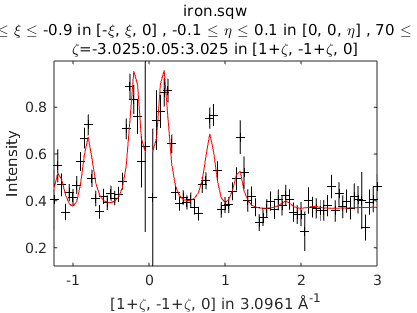

In [7]:
# Parameters for the form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114

# Define a linear background
linear_bg = m.eval('@linear_bg')

# Define the Python function
def fm_sqw(h, k, l, E, p):
    J = p[0]
    Gamma = p[1]
    Amp = p[2]
    E0 = 8*J * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    Biso = E / (1 - np.exp(-1.602 * E / 10))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (Amp * Biso * 4 * Gamma * E0 / np.pi) / ((E**2 - E0**2)**2 + 4*(Gamma*E)**2)

J = 35      # Exchange parameter in meV
Gamma = 30  # Intrinsic linewidth in meV (inversely proportional to excitation lifetime)
Amp = 300   # Magnitude of the intensity of the excitation (arbitrary units)

pars_in = [J, Gamma, Amp]

mfobj = m.multifit_sqw(my_cuts[0])
mfobj = mfobj.set_fun(fm_sqw, pars_in)
mfobj = mfobj.set_bfun(linear_bg, [0.3, 0])
wfit, fitdata = mfobj.fit()

m.acolor('black')
m.plot(my_cuts[0])
m.acolor('red')
m.pl(wfit)

print(fitdata)

If you're satisfied with fitting the first cut there, now try to fit all the cuts (at different energies) we made at the start.

This can be done simply by give the full list of cuts to `multifit_sqw` when you construct it instead of just the first cut. Everything else will stay the same.



{'p': array([[ 36.82309749,  68.22658257, 420.44211508]]), 'sig': array([[ 0.34483276,  2.73559281, 12.73379338]]), 'bp': [array([[0.37008001, 0.0005645 ]]), array([[0.19588428, 0.00673257]]), array([[0.10779168, 0.00539775]]), array([[ 0.06471982, -0.00174459]]), array([[4.11065705e-02, 5.87913063e-05]])], 'bsig': [array([[0.00779254, 0.00560622]]), array([[0.00558309, 0.00397068]]), array([[0.00420659, 0.00288796]]), array([[0.00351609, 0.00218943]]), array([[0.00305819, 0.00178638]])], 'corr': array([[ 1.        ,  0.85219527,  0.7968446 , -0.12266109,  0.0591787 ,
        -0.20457351,  0.09966473, -0.32841737,  0.16654808, -0.41633691,
         0.23848385, -0.34010595,  0.20031847],
       [ 0.85219527,  1.        ,  0.88848208, -0.1689428 ,  0.08102924,
        -0.25836928,  0.12423985, -0.39454638,  0.19835667, -0.50084141,
         0.28417625, -0.49495194,  0.2915687 ],
       [ 0.7968446 ,  0.88848208,  1.        , -0.22154354,  0.10744622,
        -0.34201129,  0.1658828 , -

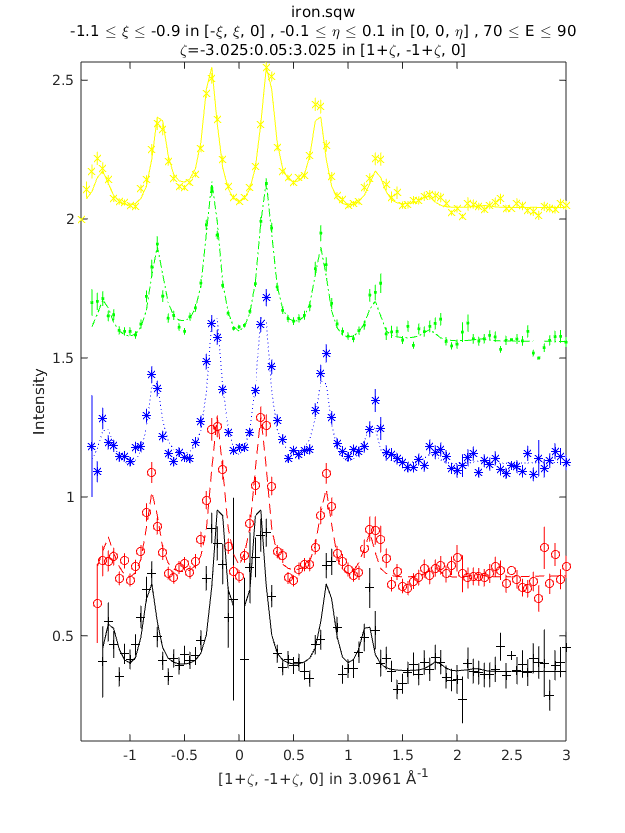

In [11]:
mfobj = m.multifit_sqw(my_cuts)
mfobj = mfobj.set_fun(fm_sqw, pars_in)
mfobj = mfobj.set_bfun(linear_bg, [0.3, 0])
wfit, fitdata = mfobj.fit()

%matlab_fig -h 800 -w 600 -r 100

# Plots the cuts using a vectorised operation, offsetting each cut by 0.5 units in y
m.acolor(['black', 'red', 'blue', 'green', 'yellow'])
m.amark(['+', 'o', '*', '.', 'x', 's'], 6)
my_cut_offset = my_cuts + np.arange(0, 2.1, 0.5)
my_fit_offset = wfit + np.arange(0, 2.1, 0.5)
m.dp(my_cut_offset)
m.pl(my_fit_offset)

print(fitdata)

In [12]:
print(fitdata['p'])

[[ 36.82309749  68.22658257 420.44211508]]


## Resolution convolution

Finally we add resolution convolution calculation to the fit. This is almost exactly the same as using `multifit_sqw` except that we now use the `tobyfit` class instead and we have to define some instrument and sample parameters. [The documentation is here](https://pace-neutrons.github.io/Horace/unstable/user_guide/Resolution_convolution.html#the-tobyfit-class)

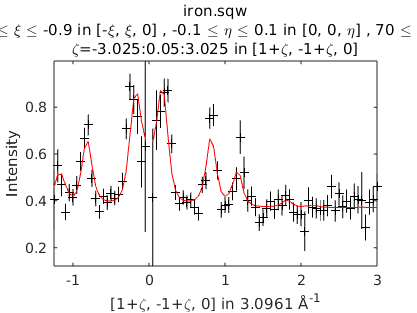

In [24]:
# Calculate spectra with full instrument resolution convolution

# Define sample parameters
xgeom = [0,0,1]
ygeom = [0,1,0]
shape = 'cuboid'
shape_pars = [0.01,0.05,0.01]

# Define instrument parameters
ei = 400    # Incident energy in meV
freq = 600  # Chopper frequency in Hz
chop = 's'  # Chopper rotor identifier (ask instrument scientist)

# Sets the sample and instrument on the workspace
my_cuts[0] = my_cuts[0].set_sample(m.IX_sample(xgeom, ygeom, shape, shape_pars))
my_cuts[0] = my_cuts[0].set_instrument(m.merlin_instrument(ei, freq, chop))

# Use previous best fit parameters
p_in = fitdata['p']

#mfobj = mfobj.set_fun(fm_sqw, pars_in)
#mfobj = mfobj.set_bfun(linear_bg, [0.3, 0])
#wfit, fitdata = mfobj.fit()

tbfobj = m.tobyfit(my_cuts[0])
tbfobj = tbfobj.set_fun(fm_sqw, fitdata['p'])  # Use previous best fit parameters
tbfobj = tbfobj.set_bfun(linear_bg, fitdata['bp'][0])
w_tbf = tbfobj.simulate()

m.acolor('black')
m.plot(my_cuts[0])
m.acolor('red')
m.pl(w_tbf)
m.acolor('blue')
m.pl(wfit[0])

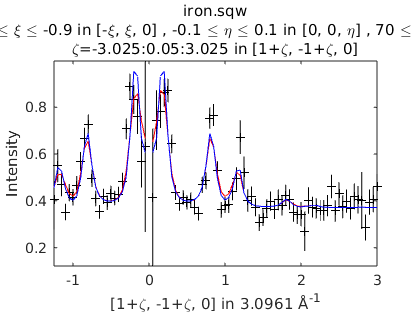

In [25]:
m.acolor('black')
m.plot(my_cuts[0])
m.acolor('red')
m.pl(w_tbf)
m.acolor('blue')
m.pl(wfit[0])

In [23]:
print(fitdata['bp'])

[array([[0.37008001, 0.0005645 ]]), array([[0.19588428, 0.00673257]]), array([[0.10779168, 0.00539775]]), array([[ 0.06471982, -0.00174459]]), array([[4.11065705e-02, 5.87913063e-05]])]
